In [12]:
import numpy as np
import os
import matplotlib.pyplot as plt
import imageio
from pathlib import Path
import glob
import cv2
import random
import fnmatch
import torch
from PIL import Image
import pandas as pd
from scipy import ndimage
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from dataset import BaseLMDB

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from templates import *
from templates_cls import *
from experiment_classifier_funetune import ClsModel

In [4]:
state = torch.load('../diffae/checkpoints/chexpert256_autoenc_cls_finetune/last.ckpt', map_location='cpu')

In [13]:
cls_conf = chexpert256_autoenc_cls_finetune()
model = ClsModel(cls_conf)
model.load_state_dict(state['state_dict'], strict=False)

Global seed set to 0


loading pretrain ... 90M
step: 7674693
loading latent stats ...


<All keys matched successfully>

In [18]:
model.ema_classifier

Linear(in_features=512, out_features=14, bias=True)

In [2]:
dataset = BaseLMDB(path = '../Stanford_MIT_CHEST/MIMIC-CXR-v2.0/lmdb/256/', original_resolution=256)

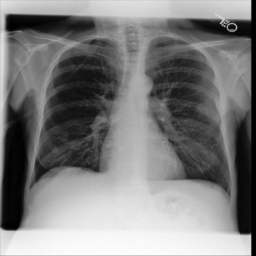

In [5]:
dataset['000001']

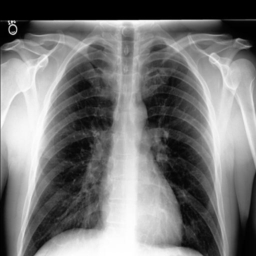

/home/titanrt/anaconda3/envs/backdoor/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  import sys


(-0.5, 511.5, 511.5, -0.5)

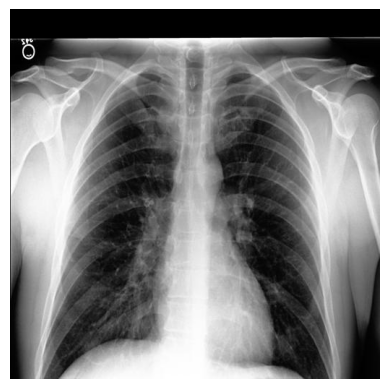

In [13]:
df = pd.read_csv('datasets/mimic/train_label.csv')
# df.head()
d_id = dict(zip(df['name'], df['dicom_id']))
idx = random.choice(df['name'])
dataset[idx.split('.')[0]]

plt.imshow(imageio.imread(os.path.join('../Stanford_MIT_CHEST/MIMIC-CXR-v2.0/mimic-cxr/', d_id[idx]+'.jpg')))
plt.axis('off')

## lmdb and MIMIC dicom id

In [4]:
df = pd.read_csv('../Stanford_MIT_CHEST/MIMIC-CXR-v2.0/csvs/mimicfrontal_label.csv')
df = df[df['split'] == 'train']
filenames = [os.path.join('../Stanford_MIT_CHEST/MIMIC-CXR-v2.0/mimic-cxr', x+'.jpg') for x in df['dicom_id']]
# filenames = sorted(filenames)
df.head()

,dicom_id,study_id,subject_id,split,view,gender,race,Atelectasis,Cardiomegaly,Consolidation,...,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,50414267,10000032,train,PA,F,WHITE,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,53189527,10000032,train,PA,F,WHITE,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,53911762,10000032,train,AP,F,WHITE,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,53911762,10000032,train,AP,F,WHITE,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,56699142,10000032,train,AP,F,WHITE,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [11]:
print(str(1).zfill(6))

000001


In [5]:
import shutil
dnames = []
for n, file in tqdm(enumerate(filenames)):
    dname = str(n).zfill(6) + '.jpg'
    dnames.append(dname)
    shutil.copyfile(file, os.path.join('../Stanford_MIT_CHEST/MIMIC-CXR-v2.0/mimic_cxr_train/', dname))
df['name'] = dnames

2817it [00:26, 106.50it/s]


KeyboardInterrupt: 

In [20]:
path = '../Medical_AT/label/cheXPert_label.csv'
df = pd.read_csv(path)
df.head()
len(df)

,Path,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Image Index,fold
0,CheXpert-v1.0/train/patient00001/study1/view1_...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,train
1,CheXpert-v1.0/train/patient00002/study2/view1_...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1,train
2,CheXpert-v1.0/train/patient00002/study1/view1_...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,train
3,CheXpert-v1.0/train/patient00003/study1/view1_...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,train
4,CheXpert-v1.0/train/patient00004/study1/view1_...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,train


191229

In [3]:
img_names = sorted(glob.glob('../CheXpert_Dataset/images_256/images/*.png'))

In [21]:
len(img_names)
df['name'] = [os.path.basename(x) for x in img_names]
df.head()


191229

,Path,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Image Index,fold,name
0,CheXpert-v1.0/train/patient00001/study1/view1_...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,train,000000.png
1,CheXpert-v1.0/train/patient00002/study2/view1_...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1,train,000001.png
2,CheXpert-v1.0/train/patient00002/study1/view1_...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,train,000002.png
3,CheXpert-v1.0/train/patient00003/study1/view1_...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,train,000003.png
4,CheXpert-v1.0/train/patient00004/study1/view1_...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,train,000004.png


In [30]:
df.to_csv('../diffae/datasets/chexpert/label.csv', index=False)

In [29]:
row = df.iloc[0]
row['name']

index = 1
PRED_LABEL = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 
                'Lung Opacity', 'Lung Lesion', 'Edema', 
                'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 
                'Fracture', 'Support Devices'
            ]

labels = np.zeros(len(PRED_LABEL), dtype=int)
for i in range(0, len(PRED_LABEL)):
    if(df[PRED_LABEL[i].strip()].iloc[index].astype('int') > 0):
        labels[i] = df[PRED_LABEL[i].strip()].iloc[index].astype('int')

labels
len(labels)

'000000.png'

array([0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0])

14

/home/titanrt/anaconda3/envs/backdoor/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


/home/titanrt/anaconda3/envs/backdoor/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  This is separate from the ipykernel package so we can avoid doing imports until


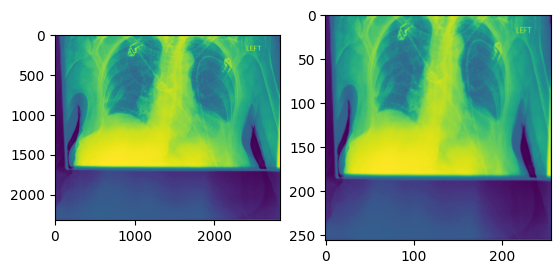

In [18]:
f, ax = plt.subplots(1, 2)
ax[0].imshow(imageio.imread(os.path.join('../Stanford_MIT_CHEST/', df['Path'][2])))
ax[1].imshow(imageio.imread(os.path.join('../CheXpert_Dataset/images_256/images/', '000002.png')))